In [27]:
import numpy as np
import matplotlib.pyplot as plt
import random

<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\O'
<>:19: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipython-input-1717789470.py:19: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(time, y, label=f'$\delta/\Omega_R$ = ' + str(interval[i]), c=generate_random_rgb_color())
/tmp/ipython-input-1717789470.py:23: SyntaxWarning: invalid escape sequence '\O'
  plt.xlabel('Time ($t\'/\Omega_R$)')


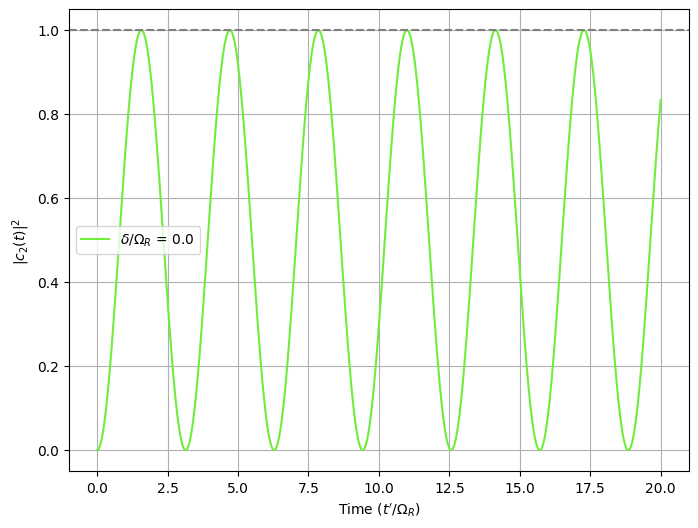

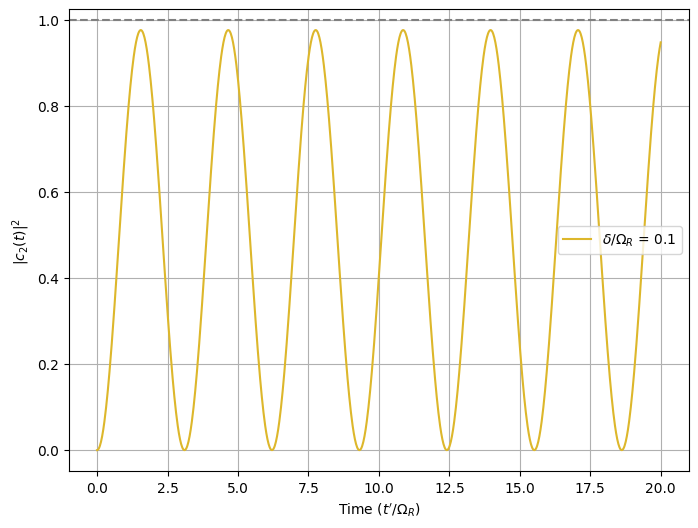

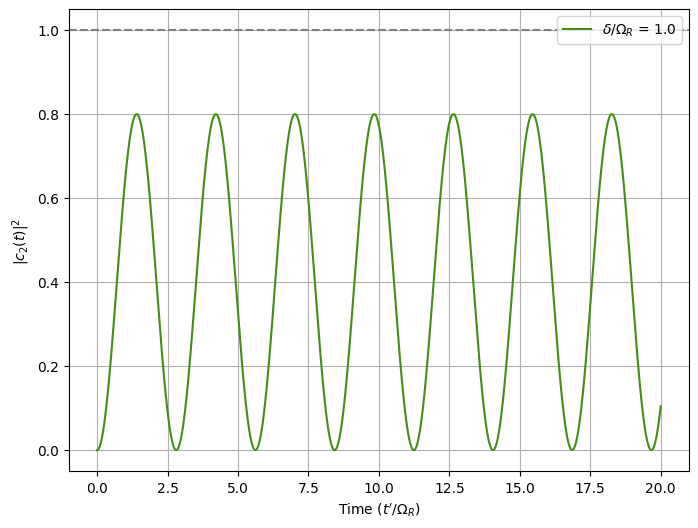

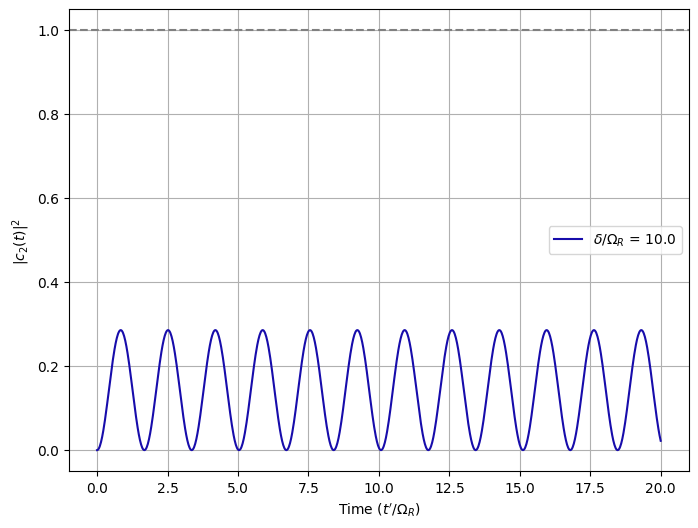

In [142]:
interval = np.array([0,0.1,1,10])
time = np.linspace(0,20,1000)
def generate_random_rgb_color():
    return (random.random(), random.random(), random.random())

def c1_amp(x, t):
  rabi_eff_ratio = np.sqrt(1 + 0.25 * (x))
  delta_eff_ratio = np.sqrt(1/((1/x)**2+0.25))
  return [np.cos(rabi_eff_ratio) - 1j * 0.5 * delta_eff_ratio * np.sin(rabi_eff_ratio*t)] * np.exp(1j * 0.5 *x)

def c2_amp(x, t):
  rabi_eff_ratio = np.sqrt(1 + 0.25 * (x))
  return 1j * 1/rabi_eff_ratio * np.sin(rabi_eff_ratio * t) * np.exp(-1j * x * 0.5)


for i in range(len(interval)):
  plt.figure(figsize=(8,6))
  y = abs(c2_amp(interval[i], time))**2
  plt.plot(time, y, label=f'$\delta/\Omega_R$ = ' + str(interval[i]), c=generate_random_rgb_color())
  plt.legend(loc='best')
  plt.grid(True)
  plt.axhline(y=1, linestyle='--', c='gray')
  plt.xlabel('Time ($t\'/\Omega_R$)')
  plt.ylabel('$|c_2(t)|^2$')
  plt.show()



In [3]:
import scipy.constants as sc

In [163]:
# 1. Setup Constants
L = 1e-9  # Assuming 1 nm (L=1 meter is too big for quantum effects usually)

w12 = 1.0 # Let's normalize w12 to 1 for the simulation to ensure timescales match
freq_set = np.array([0.1, 0.3, 0.5, 1.0]) * w12 # Scaling frequency relative to w12
t_span = np.array([0, 500]) # Increase time to see oscillations
k = t_span[1]*10
t_eval = np.linspace(t_span[0], t_span[1], k)

# (The distance between two time points)
dt = t_eval[1] - t_eval[0]

c1 = np.zeros(len(t_eval), dtype=complex)
c2 = np.zeros(len(t_eval), dtype=complex)

c1_RWA = np.zeros(len(t_eval), dtype=complex)
c2_RWA = np.zeros(len(t_eval), dtype=complex)


# Define the coupled derivatives function
def get_derivatives(t, c1_val, c2_val, omega_R):
    dc1 = 1j * omega_R * (1 + np.exp(-2j * t * w12)) * c2_val
    dc2 = 1j * omega_R * (1 + np.exp( 2j * t * w12)) * c1_val
    return dc1, dc2

def RWA_approx(t, c1_val, c2_val, omega_R):
    dc1 = 1j * omega_R * c2_val
    dc2 = 1j * omega_R * c1_val
    return dc1, dc2


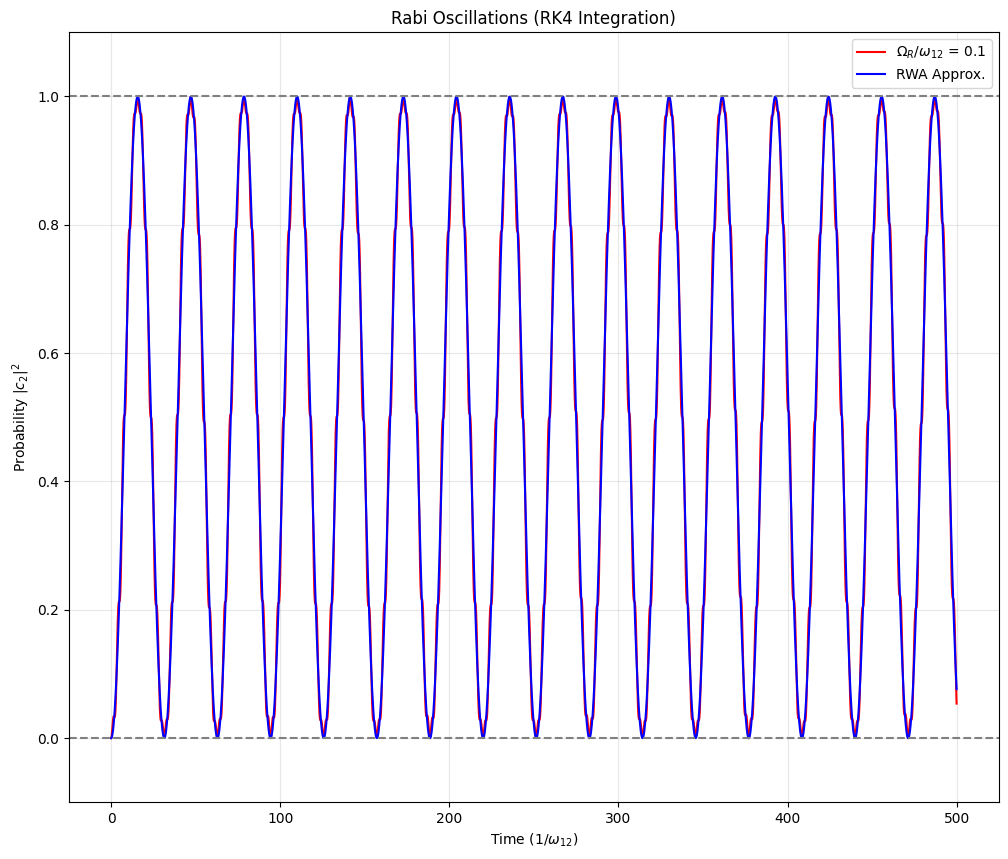

In [164]:
c1[0] = 1 + 0j
c2[0] = 0 + 0j

c1_RWA[0] = 1 + 0j
c2_RWA[0] = 0 + 0j

    # RK4 Integration Loop
for j in range(len(t_eval) - 1):
    t_curr = t_eval[j]
    c1_n = c1[j]
    c2_n = c2[j]

    c1_RWA_n = c1_RWA[j]
    c2_RWA_n = c2_RWA[j]


        # k1
    k1_c1, k1_c2 = get_derivatives(t_curr, c1_n, c2_n, freq_set[0])
    k1_RWA_c1, k1_RWA_c2 = RWA_approx(t_curr, c1_n, c2_n, freq_set[0])


        # k2
    k2_c1, k2_c2 = get_derivatives(t_curr + dt/2,
                                       c1_n + dt/2 * k1_c1,
                                       c2_n + dt/2 * k1_c2, freq_set[0])
    k2_RWA_c1, k2_RWA_c2 = RWA_approx(t_curr + dt/2,
                                       c1_RWA_n + dt/2 * k1_RWA_c1,
                                       c2_RWA_n + dt/2 * k1_RWA_c2, freq_set[0])



        # k3
    k3_c1, k3_c2 = get_derivatives(t_curr + dt/2,
                                       c1_RWA_n + dt/2 * k2_c1,
                                       c2_RWA_n + dt/2 * k2_c2, freq_set[0])

    k3_RWA_c1, k3_RWA_c2 = RWA_approx(t_curr + dt/2,
                                       c1_RWA_n + dt/2 * k2_RWA_c1,
                                       c2_RWA_n + dt/2 * k2_RWA_c2, freq_set[0])

        # k4
    k4_c1, k4_c2 = get_derivatives(t_curr + dt,
                                       c1_RWA_n + dt * k3_c1,
                                       c2_RWA_n + dt * k3_c2, freq_set[0])

    k4_RWA_c1, k4_RWA_c2 = RWA_approx(t_curr + dt,
                                       c1_RWA_n + dt * k3_RWA_c1,
                                       c2_RWA_n + dt * k3_RWA_c2, freq_set[0])


        # Update
    c1[j+1] = c1_n + (dt / 6) * (k1_c1 + 2*k2_c1 + 2*k3_c1 + k4_c1)
    c2[j+1] = c2_n + (dt / 6) * (k1_c2 + 2*k2_c2 + 2*k3_c2 + k4_c2)

    c1_RWA[j+1] = c1_RWA_n + (dt / 6) * (k1_RWA_c1 + 2*k2_RWA_c1 + 2*k3_RWA_c1 + k4_RWA_c1)
    c2_RWA[j+1] = c2_RWA_n + (dt / 6) * (k1_RWA_c2 + 2*k2_RWA_c2 + 2*k3_RWA_c2 + k4_RWA_c2)




    # Plotting Probability of State 2
    norm = abs(c1)**2 + abs(c2)**2
    norm_RWA = abs(c1_RWA)**2 + abs(c2_RWA)**2

plt.figure(figsize=(12,10))
plt.plot(t_eval, abs(c2)**2/norm, label=f'$\\Omega_R/\\omega_{{12}}$ = {freq_set[0]/w12:.1f}', c='red')
plt.plot(t_eval, abs(c2_RWA)**2/norm_RWA, label='RWA Approx.', c='blue')
plt.title("Rabi Oscillations (RK4 Integration)")
plt.xlabel("Time ($1/\\omega_{12}$)")
plt.ylabel("Probability $|c_2|^2$")
plt.ylim(-0.1, 1.1) # Verify normalization stays within bounds
plt.axhline(y=1, linestyle='--', c='gray')
plt.axhline(y=0, linestyle='--', c='gray')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

<>:80: SyntaxWarning: invalid escape sequence '\O'
<>:83: SyntaxWarning: invalid escape sequence '\o'
<>:80: SyntaxWarning: invalid escape sequence '\O'
<>:83: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-344362911.py:80: SyntaxWarning: invalid escape sequence '\O'
  plt.plot(t_eval, abs(c2)**2/norm, label=f'$\Omega_R/\omega_{{12}}$ = {freq/w12:.1f}', c='red')
/tmp/ipython-input-344362911.py:83: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("Time ($1/\omega_{12}$)")


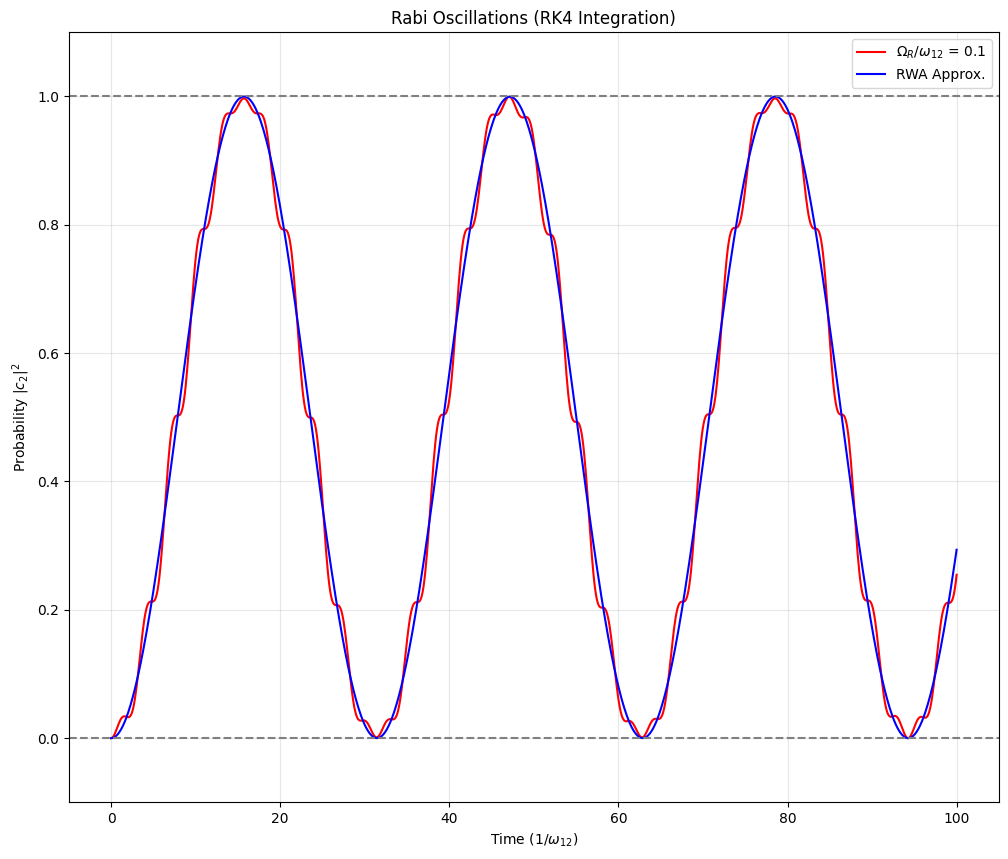

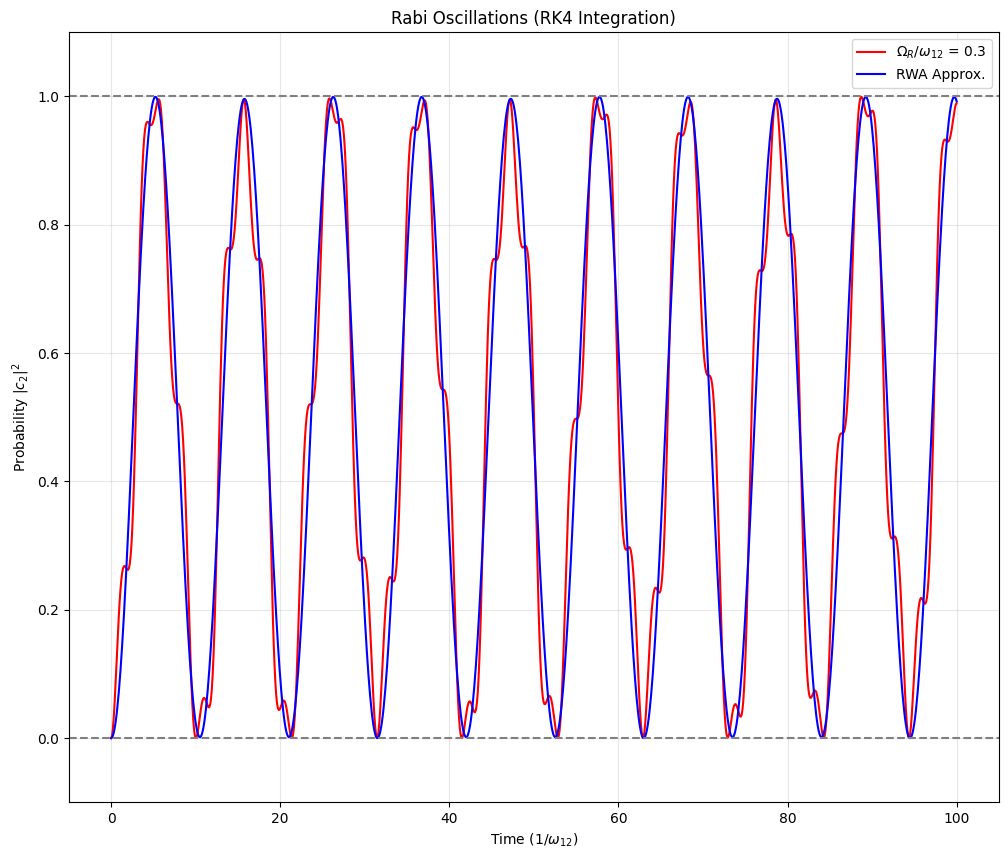

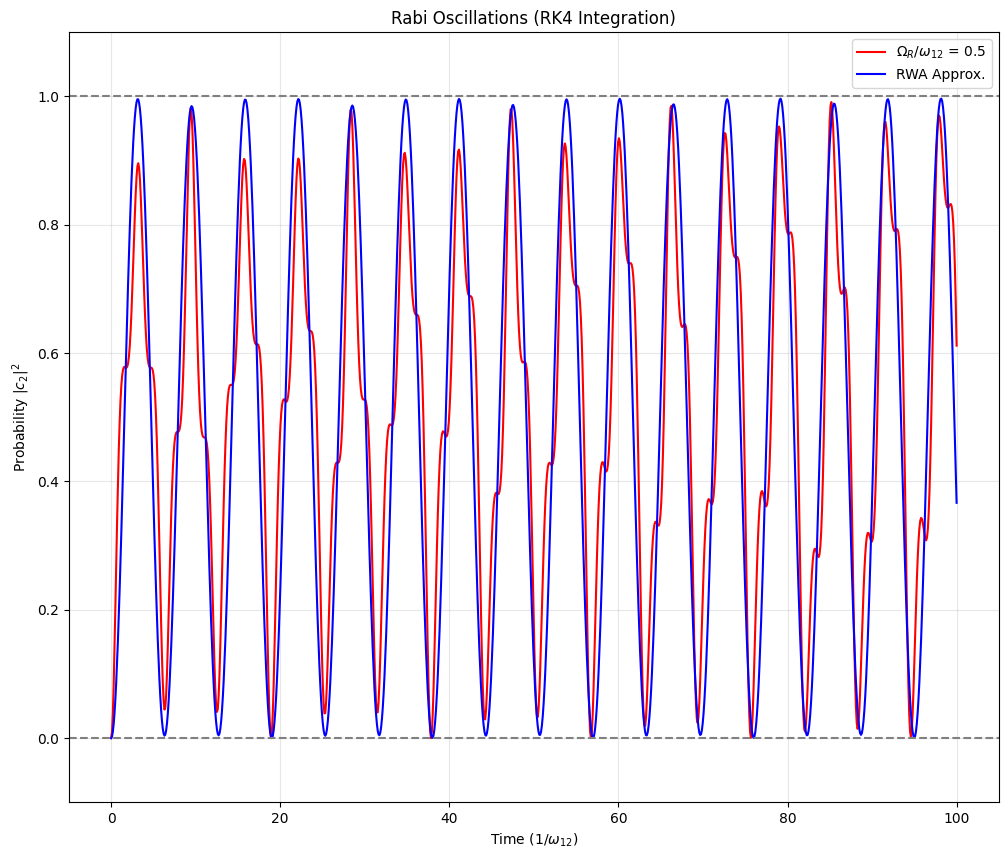

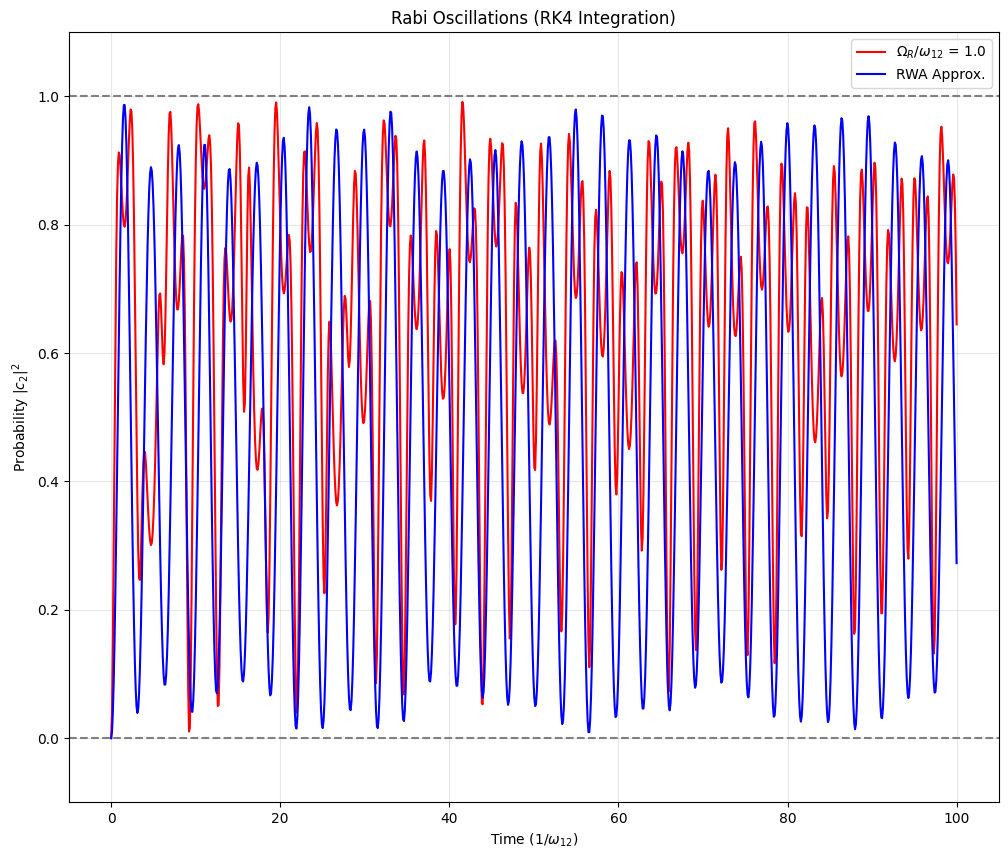

In [165]:
t_span = np.array([0, 100]) # Increase time to see oscillations
k = 1000
t_eval = np.linspace(t_span[0], t_span[1], k)

# (The distance between two time points)
dt = t_eval[1] - t_eval[0]

c1 = np.zeros(len(t_eval), dtype=complex)
c2 = np.zeros(len(t_eval), dtype=complex)

c1_RWA = np.zeros(len(t_eval), dtype=complex)
c2_RWA = np.zeros(len(t_eval), dtype=complex)

for freq in freq_set:
    c1[0] = 1 + 0j
    c2[0] = 0 + 0j

    c1_RWA[0] = 1 + 0j
    c2_RWA[0] = 0 + 0j

    # RK4 Integration Loop
    for j in range(len(t_eval) - 1):
        t_curr = t_eval[j]
        c1_n = c1[j]
        c2_n = c2[j]

        c1_RWA_n = c1_RWA[j]
        c2_RWA_n = c2_RWA[j]


        # k1
        k1_c1, k1_c2 = get_derivatives(t_curr, c1_n, c2_n, freq)
        k1_RWA_c1, k1_RWA_c2 = RWA_approx(t_curr, c1_n, c2_n, freq)


        # k2
        k2_c1, k2_c2 = get_derivatives(t_curr + dt/2,
                                       c1_n + dt/2 * k1_c1,
                                       c2_n + dt/2 * k1_c2, freq)
        k2_RWA_c1, k2_RWA_c2 = RWA_approx(t_curr + dt/2,
                                       c1_RWA_n + dt/2 * k1_RWA_c1,
                                       c2_RWA_n + dt/2 * k1_RWA_c2, freq)



        # k3
        k3_c1, k3_c2 = get_derivatives(t_curr + dt/2,
                                       c1_RWA_n + dt/2 * k2_c1,
                                       c2_RWA_n + dt/2 * k2_c2, freq)

        k3_RWA_c1, k3_RWA_c2 = RWA_approx(t_curr + dt/2,
                                       c1_RWA_n + dt/2 * k2_RWA_c1,
                                       c2_RWA_n + dt/2 * k2_RWA_c2, freq)

        # k4
        k4_c1, k4_c2 = get_derivatives(t_curr + dt,
                                       c1_RWA_n + dt * k3_c1,
                                       c2_RWA_n + dt * k3_c2, freq)

        k4_RWA_c1, k4_RWA_c2 = RWA_approx(t_curr + dt,
                                       c1_RWA_n + dt * k3_RWA_c1,
                                       c2_RWA_n + dt * k3_RWA_c2, freq)


        # Update
        c1[j+1] = c1_n + (dt / 6) * (k1_c1 + 2*k2_c1 + 2*k3_c1 + k4_c1)
        c2[j+1] = c2_n + (dt / 6) * (k1_c2 + 2*k2_c2 + 2*k3_c2 + k4_c2)

        c1_RWA[j+1] = c1_RWA_n + (dt / 6) * (k1_RWA_c1 + 2*k2_RWA_c1 + 2*k3_RWA_c1 + k4_RWA_c1)
        c2_RWA[j+1] = c2_RWA_n + (dt / 6) * (k1_RWA_c2 + 2*k2_RWA_c2 + 2*k3_RWA_c2 + k4_RWA_c2)




    # Plotting Probability of State 2
    norm = abs(c1)**2 + abs(c2)**2
    norm_RWA = abs(c1_RWA)**2 + abs(c2_RWA)**2

    plt.figure(figsize=(12,10))
    plt.plot(t_eval, abs(c2)**2/norm, label=f'$\Omega_R/\omega_{{12}}$ = {freq/w12:.1f}', c='red')
    plt.plot(t_eval, abs(c2_RWA)**2/norm_RWA, label='RWA Approx.', c='blue')
    plt.title("Rabi Oscillations (RK4 Integration)")
    plt.xlabel("Time ($1/\omega_{12}$)")
    plt.ylabel("Probability $|c_2|^2$")
    plt.ylim(-0.1, 1.1) # Verify normalization stays within bounds
    plt.axhline(y=1, linestyle='--', c='gray')
    plt.axhline(y=0, linestyle='--', c='gray')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()



In [6]:
from scipy.fft import fft, fftfreq

In [117]:
def compute_amplitudes(t, c1_val, c2_val, x):

  dt = t[1] - t[0]
  freq = x
  c1_val[0] = 1 +0j
  c2_val[0] = 0 + 0j

  for j in range(len(t)-1):
    t_curr = t[j]
    c1_n = c1_val[j]
    c2_n = c2_val[j]

    k1_c1, k1_c2 = get_derivatives(t_curr, c1_n, c2_n, freq)
    k2_c1, k2_c2 = get_derivatives(t_curr + dt/2,
                                        c1_n + dt/2 * k1_c1,
                                        c2_n + dt/2 * k1_c2, freq)
    k3_c1, k3_c2 = get_derivatives(t_curr + dt/2,
                                        c1_n + dt/2 * k2_c1,
                                        c2_n + dt/2 * k2_c2, freq)
    k4_c1, k4_c2 = get_derivatives(t_curr + dt,
                                        c1_n + dt * k3_c1,
                                        c2_n + dt * k3_c2, freq)
    c1_val[j+1] = c1_n + (dt / 6) * (k1_c1 + 2*k2_c1 + 2*k3_c1 + k4_c1)
    c2_val[j+1] = c2_n + (dt / 6) * (k1_c2 + 2*k2_c2 + 2*k3_c2 + k4_c2)

  return c1_val, c2_val


def compute_approx_amplitudes(t, c1_val, c2_val, x):

  dt = t[1] - t[0]

  freq = x
  c1_val[0] = 1 +0j
  c2_val[0] = 0 + 0j

  for j in range(len(t)-1):
    t_curr = t[j]
    c1_n = c1_val[j]
    c2_n = c2_val[j]

    k1_c1, k1_c2 = RWA_approx(t_curr, c1_n, c2_n, freq)
    k2_c1, k2_c2 = RWA_approx(t_curr + dt/2,
                                       c1_n + dt/2 * k1_c1,
                                       c2_n + dt/2 * k1_c2, freq)
    k3_c1, k3_c2 = RWA_approx(t_curr + dt/2,
                                       c1_n + dt/2 * k2_c1,
                                       c2_n + dt/2 * k2_c2, freq)
    k4_c1, k4_c2 = RWA_approx(t_curr + dt,
                                       c1_n + dt * k3_c1,
                                       c2_n + dt * k3_c2, freq)
    c1_val[j+1] = c1_n + (dt / 6) * (k1_c1 + 2*k2_c1 + 2*k3_c1 + k4_c1)
    c2_val[j+1] = c2_n + (dt / 6) * (k1_c2 + 2*k2_c2 + 2*k3_c2 + k4_c2)
  return c1_val, c2_val


<>:27: SyntaxWarning: invalid escape sequence '\O'
<>:27: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipython-input-3463964108.py:27: SyntaxWarning: invalid escape sequence '\O'
  ax[0].plot(frequencies, abs(fourier_transform), label=f'$\Omega_R/\omega_{{12}}$ = {freq/w12:.1f}',c='blue')


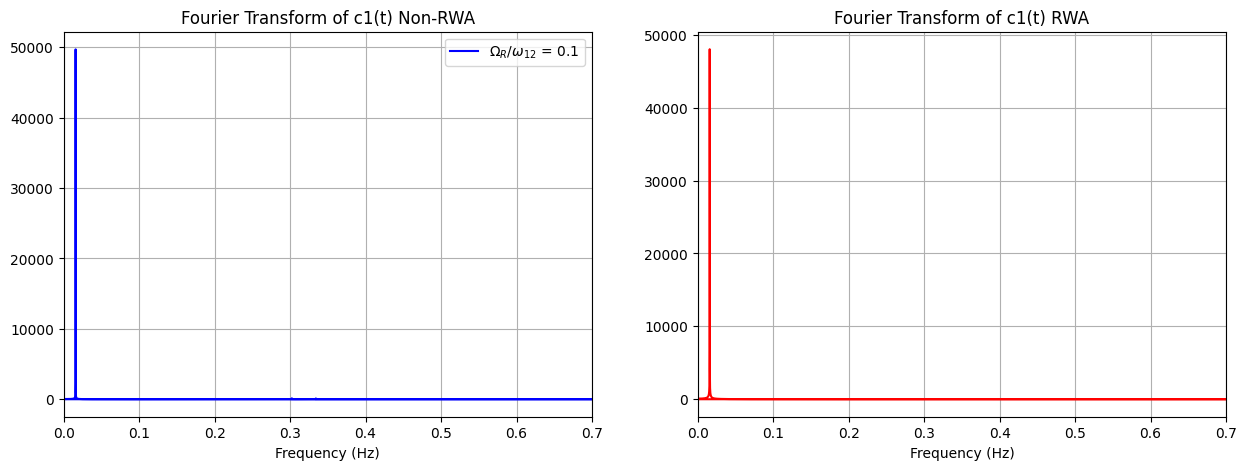

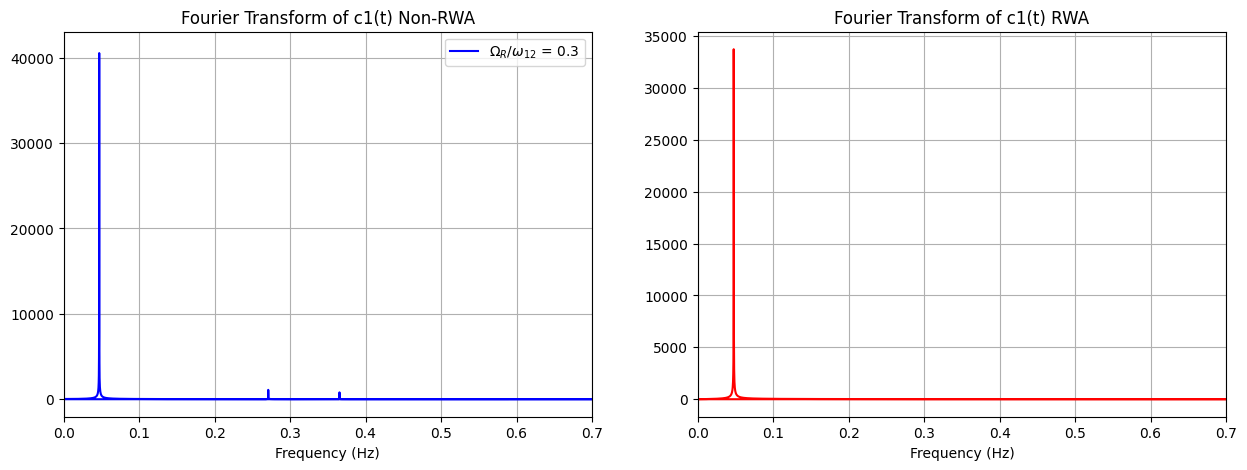

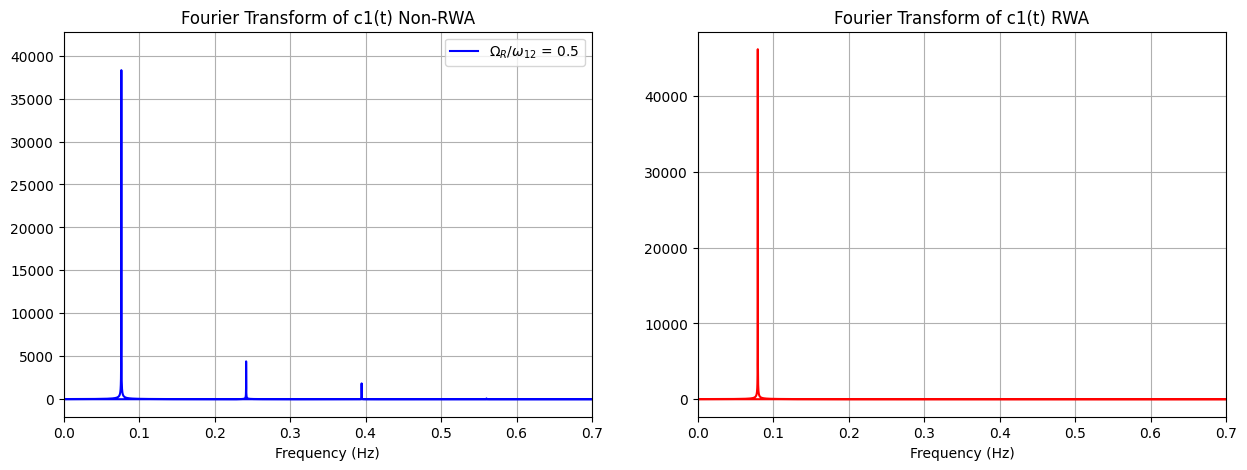

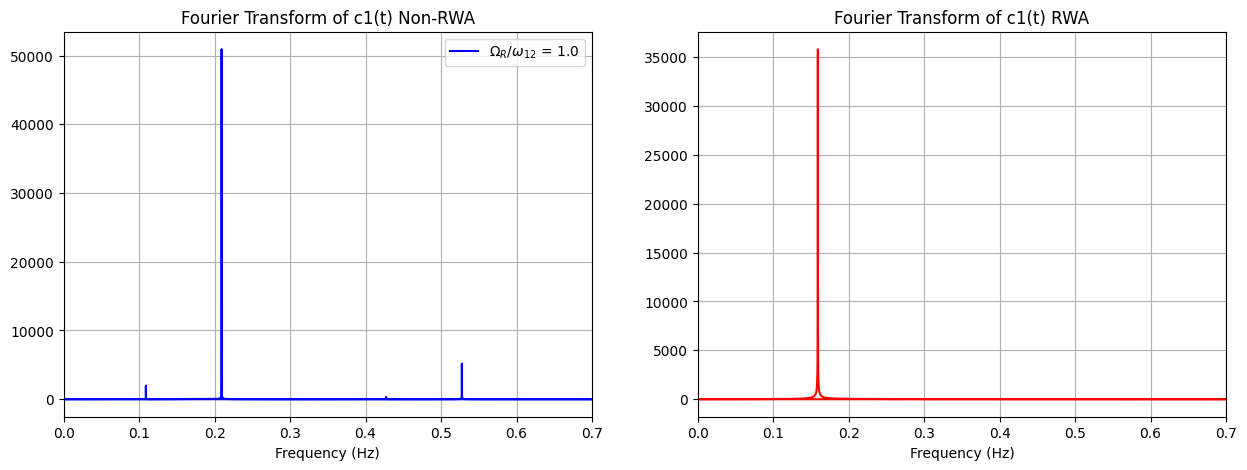

In [141]:
t_span = (0,10000)
step_time = t_span[1] * 10
time = np.linspace(t_span[0],t_span[1],step_time)

sample_rate = len(time) / time[-1]
duration = time[-1]
N = int(sample_rate*duration)

x = np.array([0.1, 0.3, 0.5, 1.0])
for freq in x:
  fig, ax = plt.subplots(1,2, figsize=(15,5))
  a, b = np.zeros(len(time), dtype=complex), np.zeros(len(time), dtype=complex)
  c,d = np.zeros(len(time), dtype=complex), np.zeros(len(time), dtype=complex)

  c1, c2 = compute_amplitudes(time, a, b, freq)
  c1_RWA, c2_RWA = compute_approx_amplitudes(time, c, d, freq)

  norm = abs(c1)**2 + abs(c2)**2
  norm_RWA = abs(c1_RWA)**2 + abs(c2_RWA)**2

  fourier_transform = np.fft.fft(c1/norm)
  frequencies = np.fft.fftfreq(N, 1/sample_rate)

  RWA_FFT = np.fft.fft(c1_RWA/norm_RWA)
  RWA_freq = np.fft.fftfreq(N, 1/sample_rate)

  ax[0].plot(frequencies, abs(fourier_transform), label=f'$\Omega_R/\omega_{{12}}$ = {freq/w12:.1f}',c='blue')
  ax[0].set_title("Fourier Transform of c1(t) Non-RWA")
  ax[0].set_xlabel('Frequency (Hz)')
  ax[0].legend(loc='best')
  ax[0].set_xlim(0,0.7)
  ax[0].grid(True)


  ax[1].plot(RWA_freq, abs(RWA_FFT), c='red')
  ax[1].set_title("Fourier Transform of c1(t) RWA")
  ax[1].set_xlabel('Frequency (Hz)')
  ax[1].set_xlim(0,0.7)
  ax[1].grid(True)


  plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\O'
<>:12: SyntaxWarning: invalid escape sequence '\O'
/tmp/ipython-input-1445323131.py:12: SyntaxWarning: invalid escape sequence '\O'
  plt.plot(frequencies, abs(fourier_transform), label=f'$\Omega_R/\omega_{{12}}$ = {freq_set[0]/w12:.1f}',c='blue')


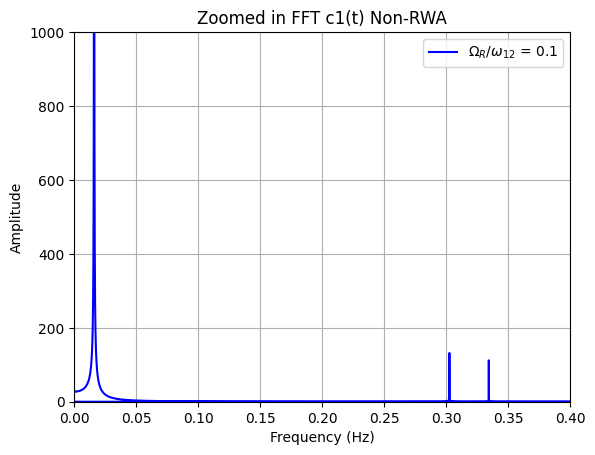

In [166]:
time = np.linspace(0,10000,100000)
sample_rate = len(time) / time[-1]
duration = time[-1]
N = int(sample_rate*duration)
x = np.zeros(len(time), dtype=complex)
y = np.zeros(len(time), dtype=complex)
c1, c2 = compute_amplitudes(time,x, y, 0.1)
norm = abs(c1)**2 + abs(c2)**2

fourier_transform = np.fft.fft(c1/norm)
frequencies = np.fft.fftfreq(N, 1/sample_rate)
plt.plot(frequencies, abs(fourier_transform), label=f'$\Omega_R/\omega_{{12}}$ = {freq_set[0]/w12:.1f}',c='blue')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title("Zoomed in FFT c1(t) Non-RWA")
plt.xlim(0,0.4)
plt.ylim(0,1000)
plt.show()